### Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sklearn.metrics as metrics
from tabulate import tabulate

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


###Set Google Drive path

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join('./dissertation/')
GOOGLE_DRIVE_PATH = os.path.join('gdrive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print('List files: ', os.listdir(GOOGLE_DRIVE_PATH))

List files:  ['data_set', 'code', 'results']


### Set file path

In [ ]:
dataset_folder = os.path.join(GOOGLE_DRIVE_PATH, 'data_set/')
inflation_data=os.path.join(dataset_folder, 'Inflation_rate.csv')
print('List files: ', os.listdir(dataset_folder))

List files:  ['Inflation_rate.csv']


###Common functions

In [ ]:
#Function to fetch data from yahoo finance
def fetch_data(ticker, start_date, end_date):
  # Fetch data using the created function
  df = yf.download(ticker, start=start_date, end=end_date)
  #Reset index
  df=df.reset_index()
  #Sort as per date ascending order
  df=df.sort_values('Date')
  # Return the DataFrame containing the fetched data
  return df

#Function to forward fill values
def fill_forward_fill_nan(df,columns):
  for col in columns:
    df[col].replace(0, float('nan'), inplace=True)
    df[col].replace('N/A', float('nan'), inplace=True)
    #df[col].fillna(method='ffill', limit=1, inplace=True)
    df[col].fillna(method='ffill', inplace=True)
  return df

#Function to describe dataset
def rounded_describe(df, decimals=3):
    print(df.describe().round(decimals))

#Function to plot graph to visualize distribution of predictor variables
def plot_columns(df, columns_to_plot, title="", x_label="Date", y_label="Price", figsize=(20, 8)):
    df_to_plot = df[columns_to_plot]
    df_to_plot.plot(figsize=figsize)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    plt.show()

###Prepare dataset

#### Data collection

In [ ]:
#Set date
start_date = '2003-01-01'
end_date = '2022-12-31'

#Get data for gold from yahoo finance
ticker_gold = 'GC=F'
gold_data_df = fetch_data(ticker_gold, start_date, end_date)
# Add dataframe name as prefix to all columns other than "Date"
gold_data_df.columns = ['Date'] + [f"Gold_{col}" for col in gold_data_df.columns if col != 'Date']

# Get data for silver from yahoo finance
ticker_silver = 'SI=F'
silver_data_df = fetch_data(ticker_silver, start_date, end_date)
# Add dataframe name as prefix to all columns other than "Date"
silver_data_df.columns = ['Date'] + [f"Silver_{col}" for col in silver_data_df.columns if col != 'Date']

# Get data for the dollar index from yahoo finance
ticker_dollar_index = 'DX-Y.NYB'
dollar_index_data_df = fetch_data(ticker_dollar_index, start_date, end_date)
# Add dataframe name as prefix to all columns other than "Date"
dollar_index_data_df.columns = ['Date'] + [f"Dollar_Index_{col}" for col in dollar_index_data_df.columns if col != 'Date']

# Get data for crude oil from yahoo finance
ticker_crude_oil = 'CL=F'
crude_oil_data_df = fetch_data(ticker_crude_oil, start_date, end_date)
# Add dataframe name as prefix to all columns other than "Date"
crude_oil_data_df.columns = ['Date'] + [f"Crude_Oil_{col}" for col in crude_oil_data_df.columns if col != 'Date']

# Get data for S&P 500(Standard & Poor's 500 Index) from yahoo finance
ticker_sp500 = '^GSPC'
sp500_data_df = fetch_data(ticker_sp500, start_date, end_date)
# Add dataframe name as prefix to all columns other than "Date"
sp500_data_df.columns = ['Date'] + [f"SP_500_{col}" for col in sp500_data_df.columns if col != 'Date']

# Get data for VIX(Volatility Index) from yahoo finance
ticker_vix = '^VIX'
vix_data_df = fetch_data(ticker_vix, start_date, end_date)
# Add dataframe name as prefix to all columns other than "Date"
vix_data_df.columns = ['Date'] + [f"Volitality_Index_{col}" for col in vix_data_df.columns if col != 'Date']

#Read inflation data file
inflation_rate_df = pd.read_csv(inflation_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# List of dataframe
datasets = [gold_data_df, silver_data_df, dollar_index_data_df, crude_oil_data_df, sp500_data_df, vix_data_df, inflation_rate_df]
rounded_stats_list = []
# Loop through each DataFrame and print the rounded descriptive statistics
for df in datasets:
    rounded_stats = rounded_describe(df)

       Gold_Open  Gold_High  Gold_Low  Gold_Close  Gold_Adj Close  Gold_Volume
count   5023.000   5023.000  5023.000    5023.000        5023.000     5023.000
mean    1161.567   1167.504  1155.252    1161.457        1161.457     4712.573
std      461.107    463.791   458.223     461.060         461.060    25783.376
min      321.000    323.500   319.300     321.500         321.500        0.000
25%      794.250    801.850   787.950     793.850         793.850       27.000
50%     1238.400   1244.400  1232.200    1239.000        1239.000      117.000
75%     1507.350   1513.900  1498.200    1506.850        1506.850      424.500
max     2053.600   2072.000  2040.000    2051.500        2051.500   386334.000
       Silver_Open  Silver_High  Silver_Low  Silver_Close  Silver_Adj Close  \
count     5024.000     5024.000    5024.000      5024.000          5024.000   
mean        17.626       17.746      17.490        17.618            17.618   
std          7.777        7.868       7.674         

In [ ]:
# Convert the Date column to datetime
inflation_rate_df['Date'] = pd.to_datetime(inflation_rate_df['Date'])

# Merge all DataFrames based on the Date column
combined_data_df = gold_data_df.merge(silver_data_df, on='Date').merge(dollar_index_data_df, on='Date').merge(crude_oil_data_df, on='Date').merge(sp500_data_df, on='Date').merge(vix_data_df, on='Date').merge(inflation_rate_df, on='Date')

# Print the combined DataFrame
print(combined_data_df)

           Date    Gold_Open    Gold_High     Gold_Low   Gold_Close  \
0    2003-01-02   346.100006   346.100006   346.100006   346.100006   
1    2003-01-03   345.200012   351.200012   345.200012   351.200012   
2    2003-01-06   351.700012   351.700012   351.100006   351.700012   
3    2003-01-07   349.299988   349.299988   347.299988   347.299988   
4    2003-01-08   346.799988   353.899994   346.299988   353.899994   
...         ...          ...          ...          ...          ...   
5015 2022-12-23  1794.300049  1802.800049  1794.099976  1795.900024   
5016 2022-12-27  1803.400024  1826.300049  1803.400024  1814.800049   
5017 2022-12-28  1803.199951  1807.900024  1803.099976  1807.900024   
5018 2022-12-29  1805.800049  1819.500000  1805.800049  1819.500000   
5019 2022-12-30  1817.000000  1822.300049  1816.800049  1819.699951   

      Gold_Adj Close  Gold_Volume  Silver_Open  Silver_High  Silver_Low  ...  \
0         346.100006            3     4.812000     4.812000    4.81

####Exploratory Data Analysis

In [ ]:
#Check dimension of data
combined_data_df.shape

(5020, 38)

In [ ]:
#Check the detail information of data
combined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        5020 non-null   datetime64[ns]
 1   Gold_Open                   5020 non-null   float64       
 2   Gold_High                   5020 non-null   float64       
 3   Gold_Low                    5020 non-null   float64       
 4   Gold_Close                  5020 non-null   float64       
 5   Gold_Adj Close              5020 non-null   float64       
 6   Gold_Volume                 5020 non-null   int64         
 7   Silver_Open                 5020 non-null   float64       
 8   Silver_High                 5020 non-null   float64       
 9   Silver_Low                  5020 non-null   float64       
 10  Silver_Close                5020 non-null   float64       
 11  Silver_Adj Close            5020 non-null   float64     

In [ ]:
#Statistical analysis of data
combined_data_df.describe()

,Gold_Open,Gold_High,Gold_Low,Gold_Close,Gold_Adj Close,Gold_Volume,Silver_Open,Silver_High,Silver_Low,Silver_Close,...,SP_500_Close,SP_500_Adj Close,SP_500_Volume,Volitality_Index_Open,Volitality_Index_High,Volitality_Index_Low,Volitality_Index_Close,Volitality_Index_Adj Close,Volitality_Index_Volume,Inflation
count,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,...,5020.000000,5020.000000,5.020000e+03,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000,5020.0,4984.000000
mean,1161.885439,1167.825797,1155.565996,1161.775418,1161.775418,4715.380876,17.629993,17.750489,17.494263,17.621825,...,1975.224575,1975.224575,3.611754e+09,19.554040,20.482819,18.620104,19.418671,19.418671,0.0,2.072125
std,461.061514,463.742962,458.179911,461.013967,461.013967,25790.824540,7.779116,7.869999,7.675918,7.771604,...,995.120447,995.120447,1.385562e+09,8.878726,9.521050,8.204439,8.822961,8.822961,0.0,0.415371
min,321.000000,323.500000,319.299988,321.500000,321.500000,0.000000,4.375000,4.380000,4.346000,4.346000,...,676.530029,676.530029,5.180600e+08,9.010000,9.310000,8.560000,9.140000,9.140000,0.0,0.040000
25%,794.650009,803.250000,789.524979,795.174988,795.174988,27.000000,13.320000,13.388750,13.205000,13.291000,...,1213.587494,1213.587494,2.821715e+09,13.570000,14.150000,13.050000,13.480000,13.480000,0.0,1.810000
50%,1238.649963,1244.500000,1232.549988,1239.200012,1239.200012,118.000000,16.840000,16.920000,16.754999,16.835000,...,1530.334961,1530.334961,3.579890e+09,17.049999,17.850000,16.270000,16.950001,16.950001,0.0,2.160000
75%,1507.549988,1514.075012,1498.425018,1507.149994,1507.149994,425.000000,21.476250,21.641500,21.307749,21.459000,...,2587.945068,2587.945068,4.290765e+09,22.719999,23.809999,21.662500,22.549999,22.549999,0.0,2.370000
max,2053.600098,2072.000000,2040.000000,2051.500000,2051.500000,386334.000000,48.459999,49.520000,47.540001,48.584000,...,4796.560059,4796.560059,1.145623e+10,82.690002,89.529999,72.760002,82.690002,82.690002,0.0,3.020000


In [ ]:
# Get the list of column names
column_names = combined_data_df.columns
for column in column_names:
    column_summary = combined_data_df[column].describe()
    print(f"Summary for Column: {column}\n")
    print(column_summary)
    print("\n")

<ipython-input-12-e87db02c1021>:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  column_summary = combined_data_df[column].describe()


Summary for Column: Date

count                    5020
unique                   5020
top       2003-01-02 00:00:00
freq                        1
first     2003-01-02 00:00:00
last      2022-12-30 00:00:00
Name: Date, dtype: object


Summary for Column: Gold_Open

count    5020.000000
mean     1161.885439
std       461.061514
min       321.000000
25%       794.650009
50%      1238.649963
75%      1507.549988
max      2053.600098
Name: Gold_Open, dtype: float64


Summary for Column: Gold_High

count    5020.000000
mean     1167.825797
std       463.742962
min       323.500000
25%       803.250000
50%      1244.500000
75%      1514.075012
max      2072.000000
Name: Gold_High, dtype: float64


Summary for Column: Gold_Low

count    5020.000000
mean     1155.565996
std       458.179911
min       319.299988
25%       789.524979
50%      1232.549988
75%      1498.425018
max      2040.000000
Name: Gold_Low, dtype: float64


Summary for Column: Gold_Close

count    5020.000000
mean     1161.77

####Visualization

In [ ]:
#Taking copy of original dataset
df=combined_data_df.copy()

In [ ]:
# Set the 'Date' column as the DataFrame's index
df.set_index('Date', inplace=True)

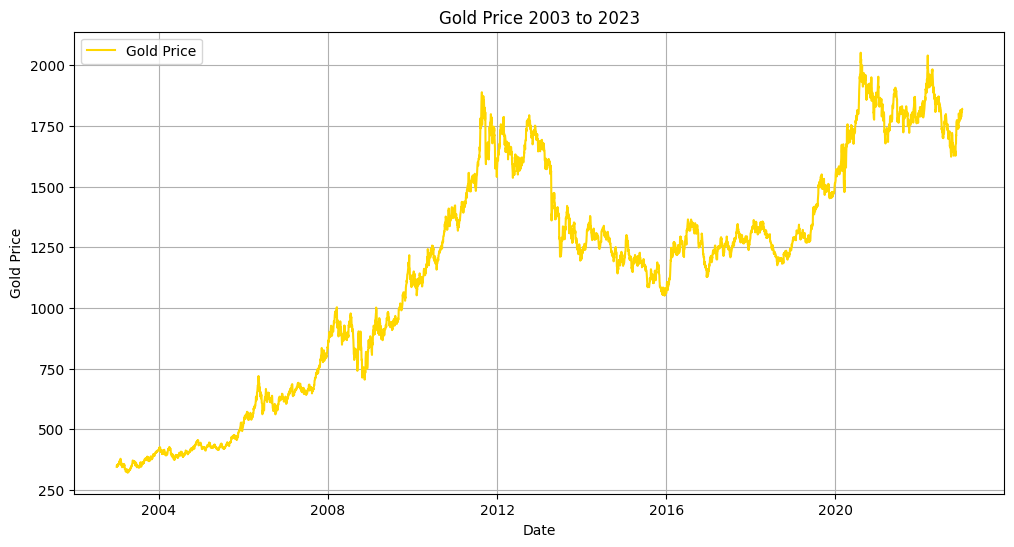

In [ ]:
# Line plot for Gold price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Gold_Adj Close'], label='Gold Price', color='gold')
plt.title("Gold Price 2003 to 2023")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid()
plt.show()

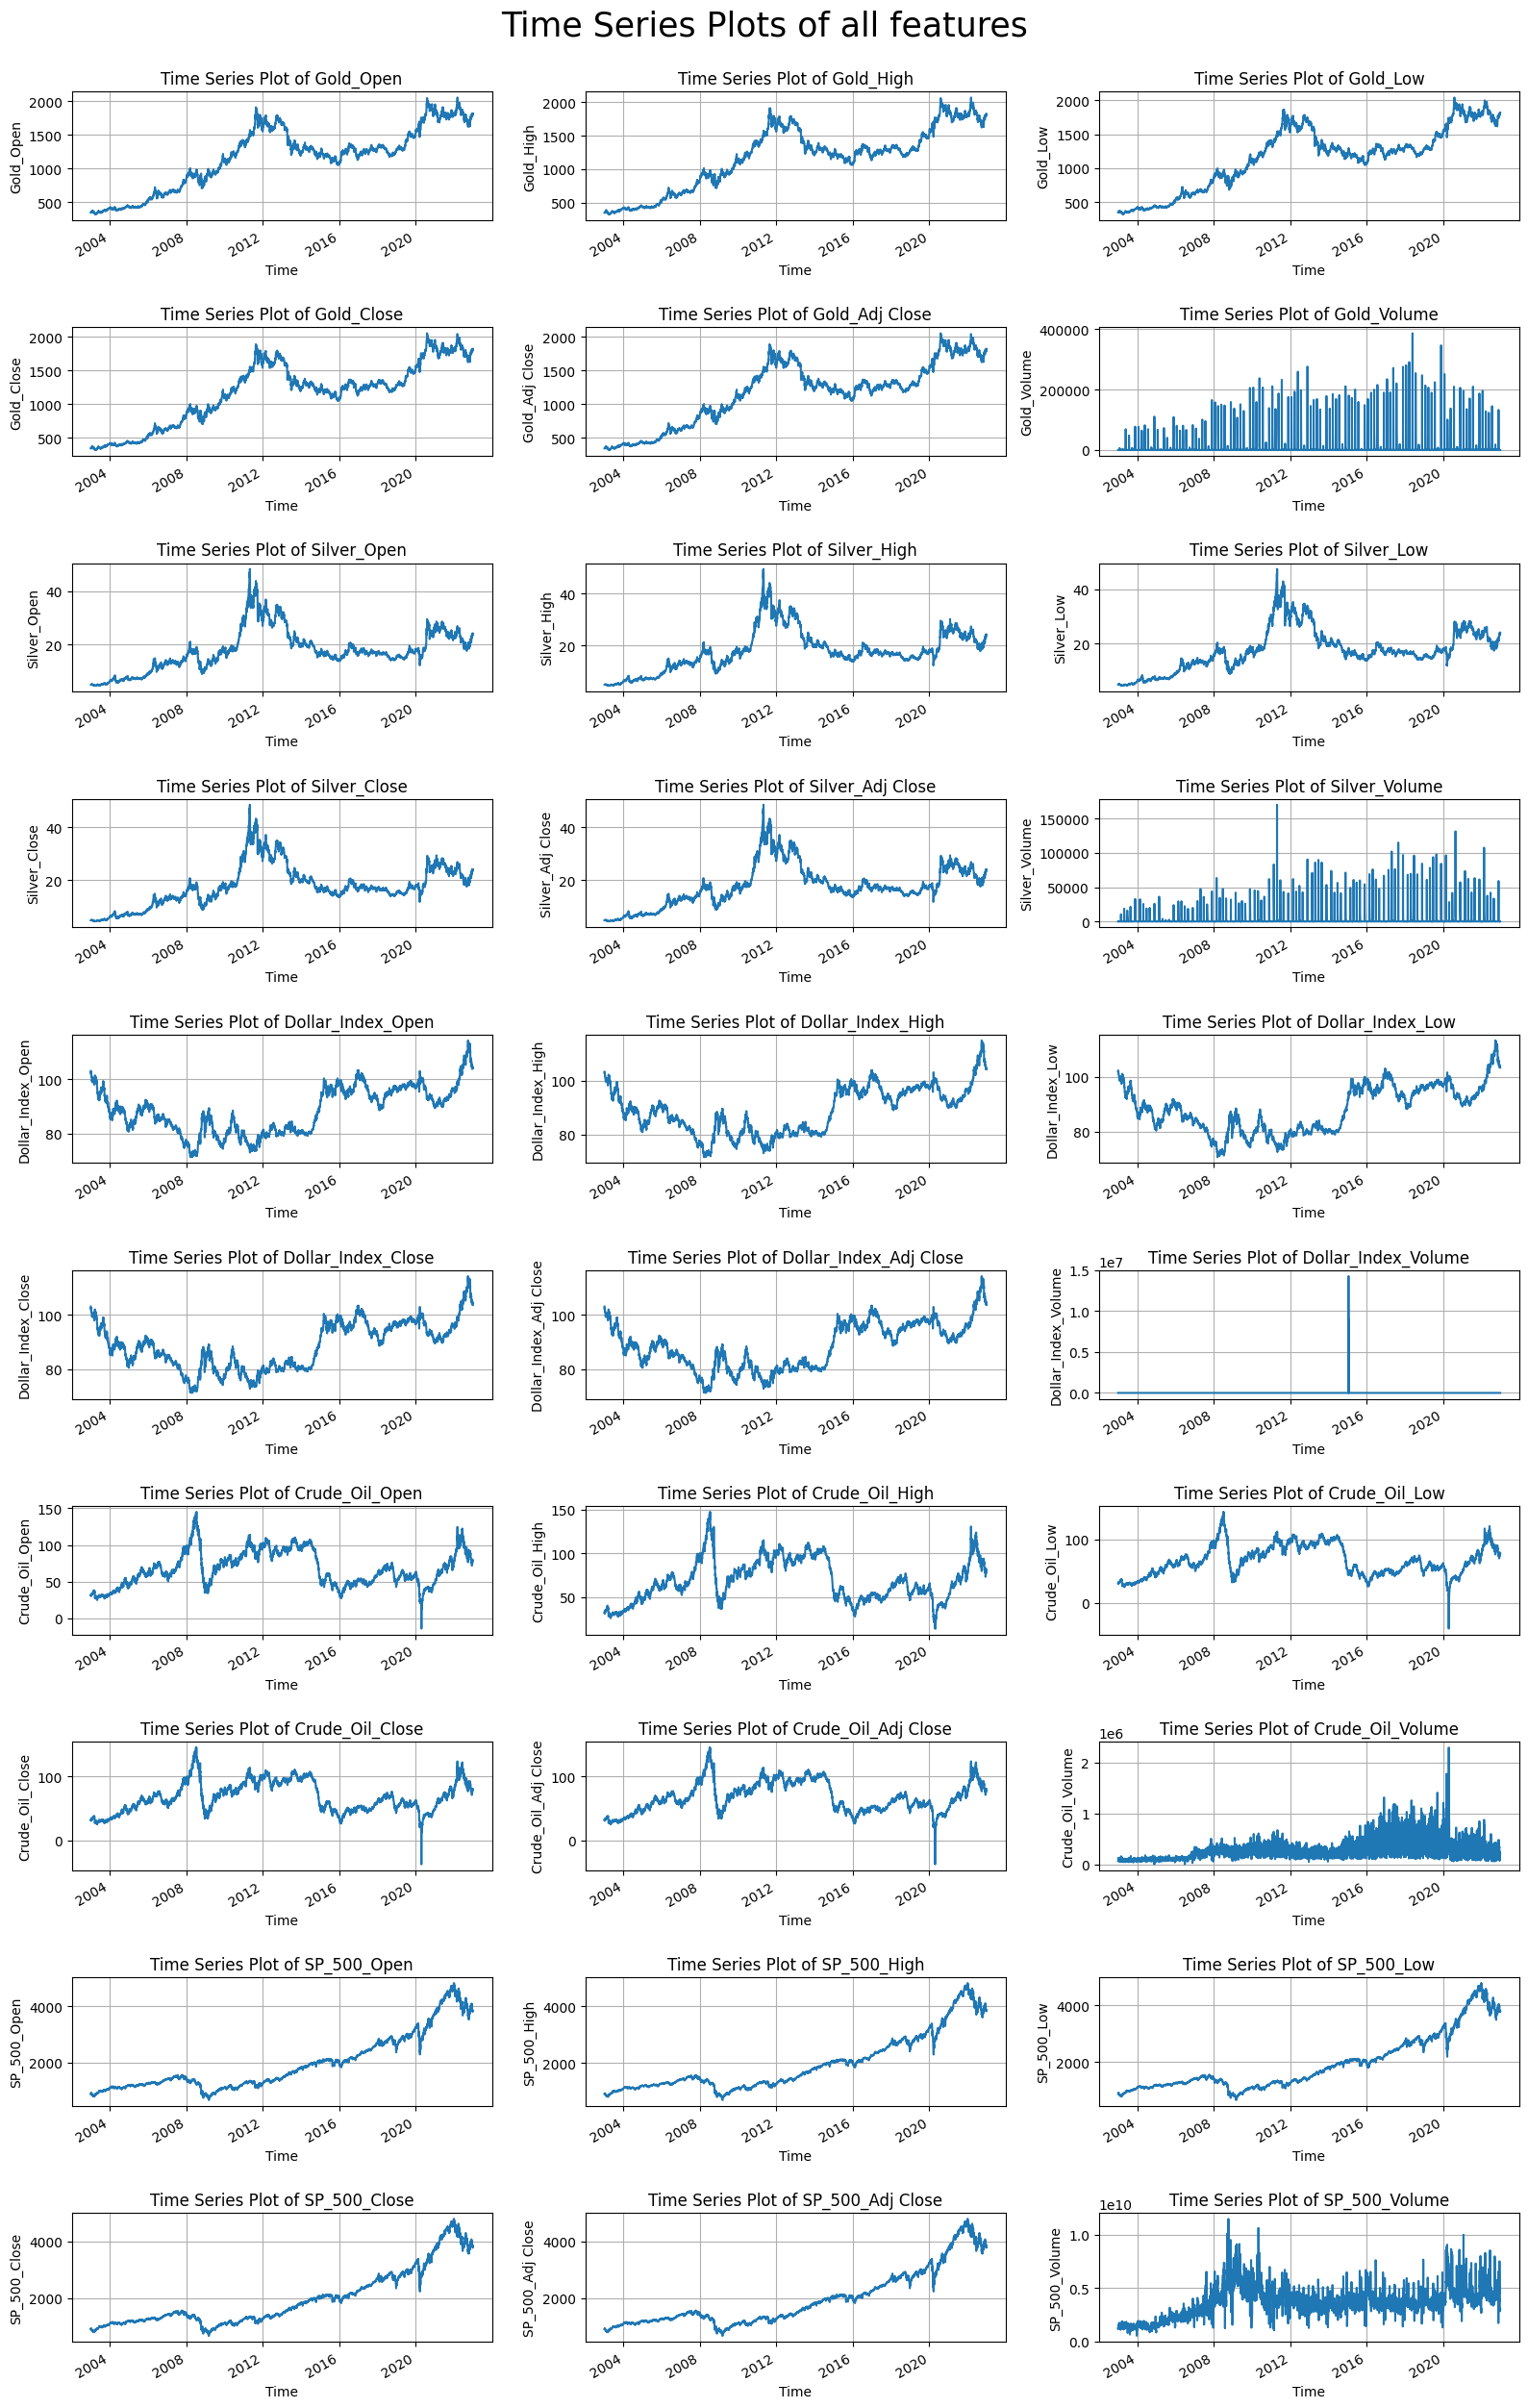

In [ ]:
def timeseries_plots(df, col_list, rows, cols, subtitle):
    fig, axs = plt.subplots(rows, cols, figsize=(16, 25))
    fig.suptitle(subtitle, y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(col_list):
        df[data].plot(ax=axs[i])
        axs[i].set_title('Time Series Plot of ' + data)
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel(data)
        axs[i].grid(True)

column_names = df.columns.tolist()

# Define the number of rows and columns for subplots
rows = 10  # Define the number of rows
cols = 3   # Define the number of columns

# Select a subset of columns to visualize
subset_columns = column_names[:rows * cols]

timeseries_plots(df, col_list=subset_columns, rows=rows, cols=cols, subtitle='Time Series Plots of all features')

plt.tight_layout()
plt.show()

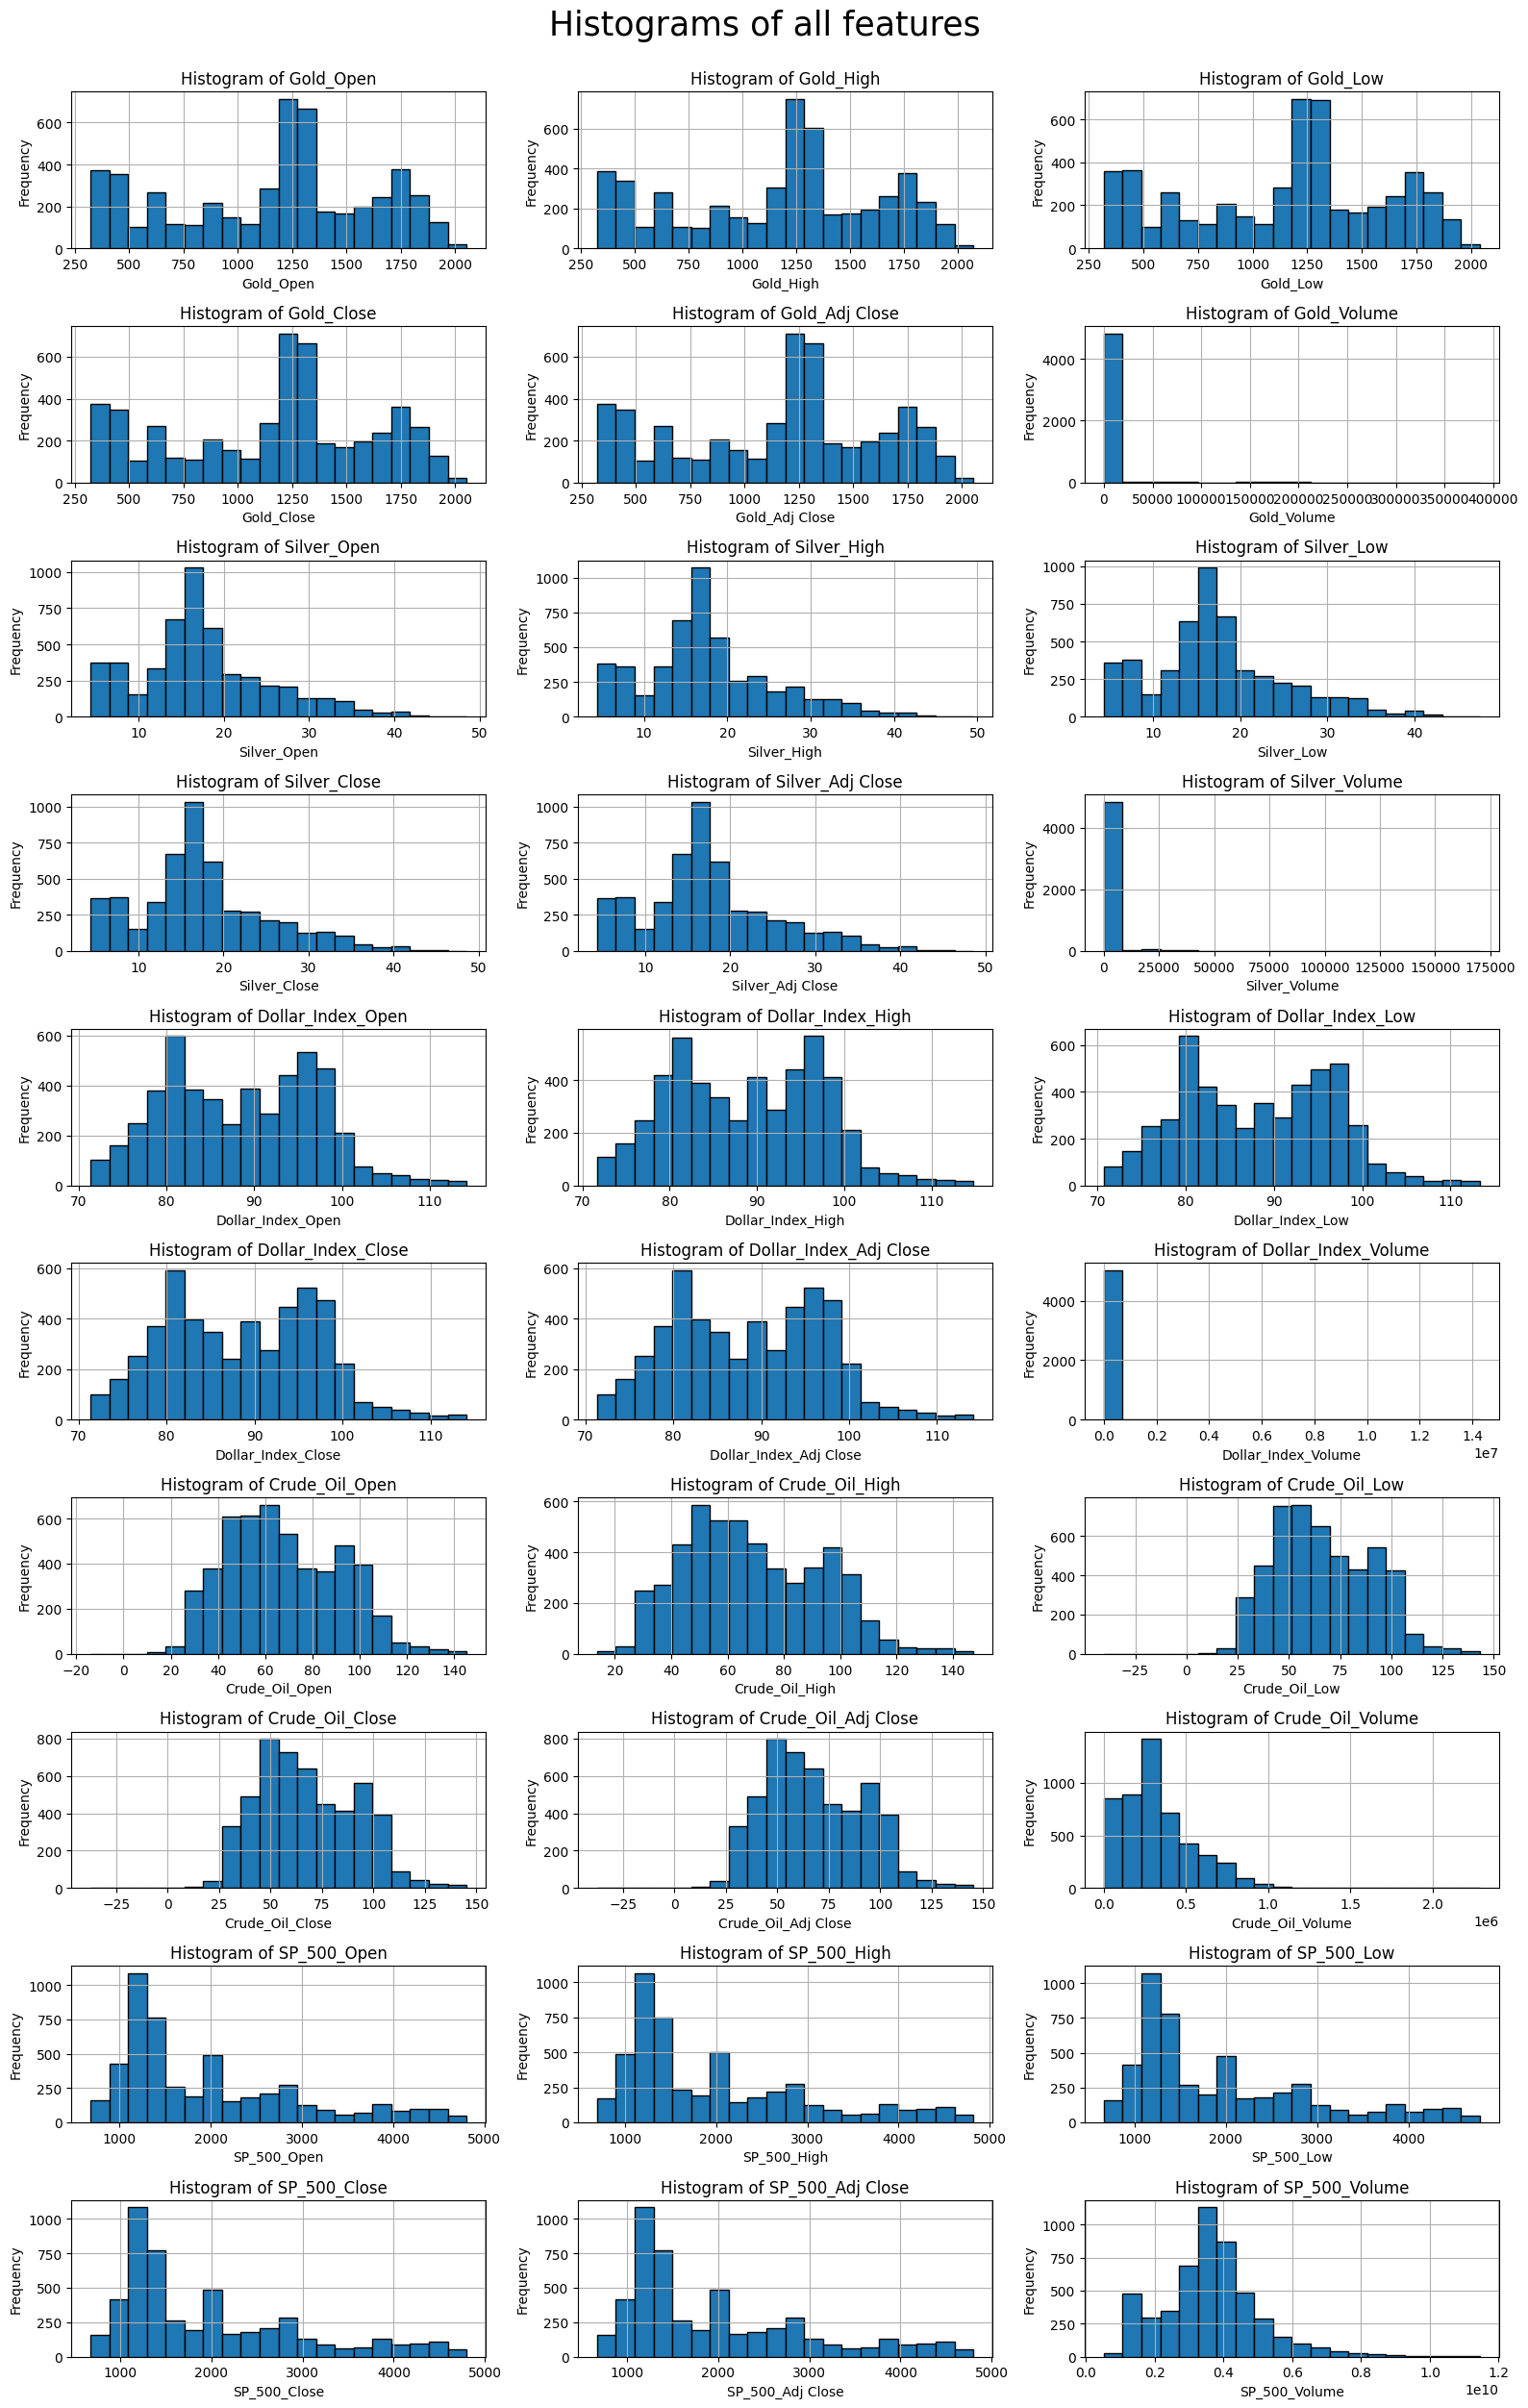

In [ ]:
def histograms(df, col_list, rows, cols, subtitle):
    fig, axs = plt.subplots(rows, cols, figsize=(16, 25))
    fig.suptitle(subtitle, y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(col_list):
        axs[i].hist(df[data], bins=20, edgecolor='black')
        axs[i].set_title('Histogram of ' + data)
        axs[i].set_xlabel(data)
        axs[i].set_ylabel('Frequency')
        axs[i].grid(True)

column_names = df.columns.tolist()

# Define the number of rows and columns for subplots
rows = 10  # Define the number of rows
cols = 3   # Define the number of columns

# Select a subset of columns to visualize
subset_columns = column_names[:rows * cols]

histograms(df, col_list=subset_columns, rows=rows, cols=cols, subtitle='Histograms of all features')

plt.tight_layout()
plt.show()

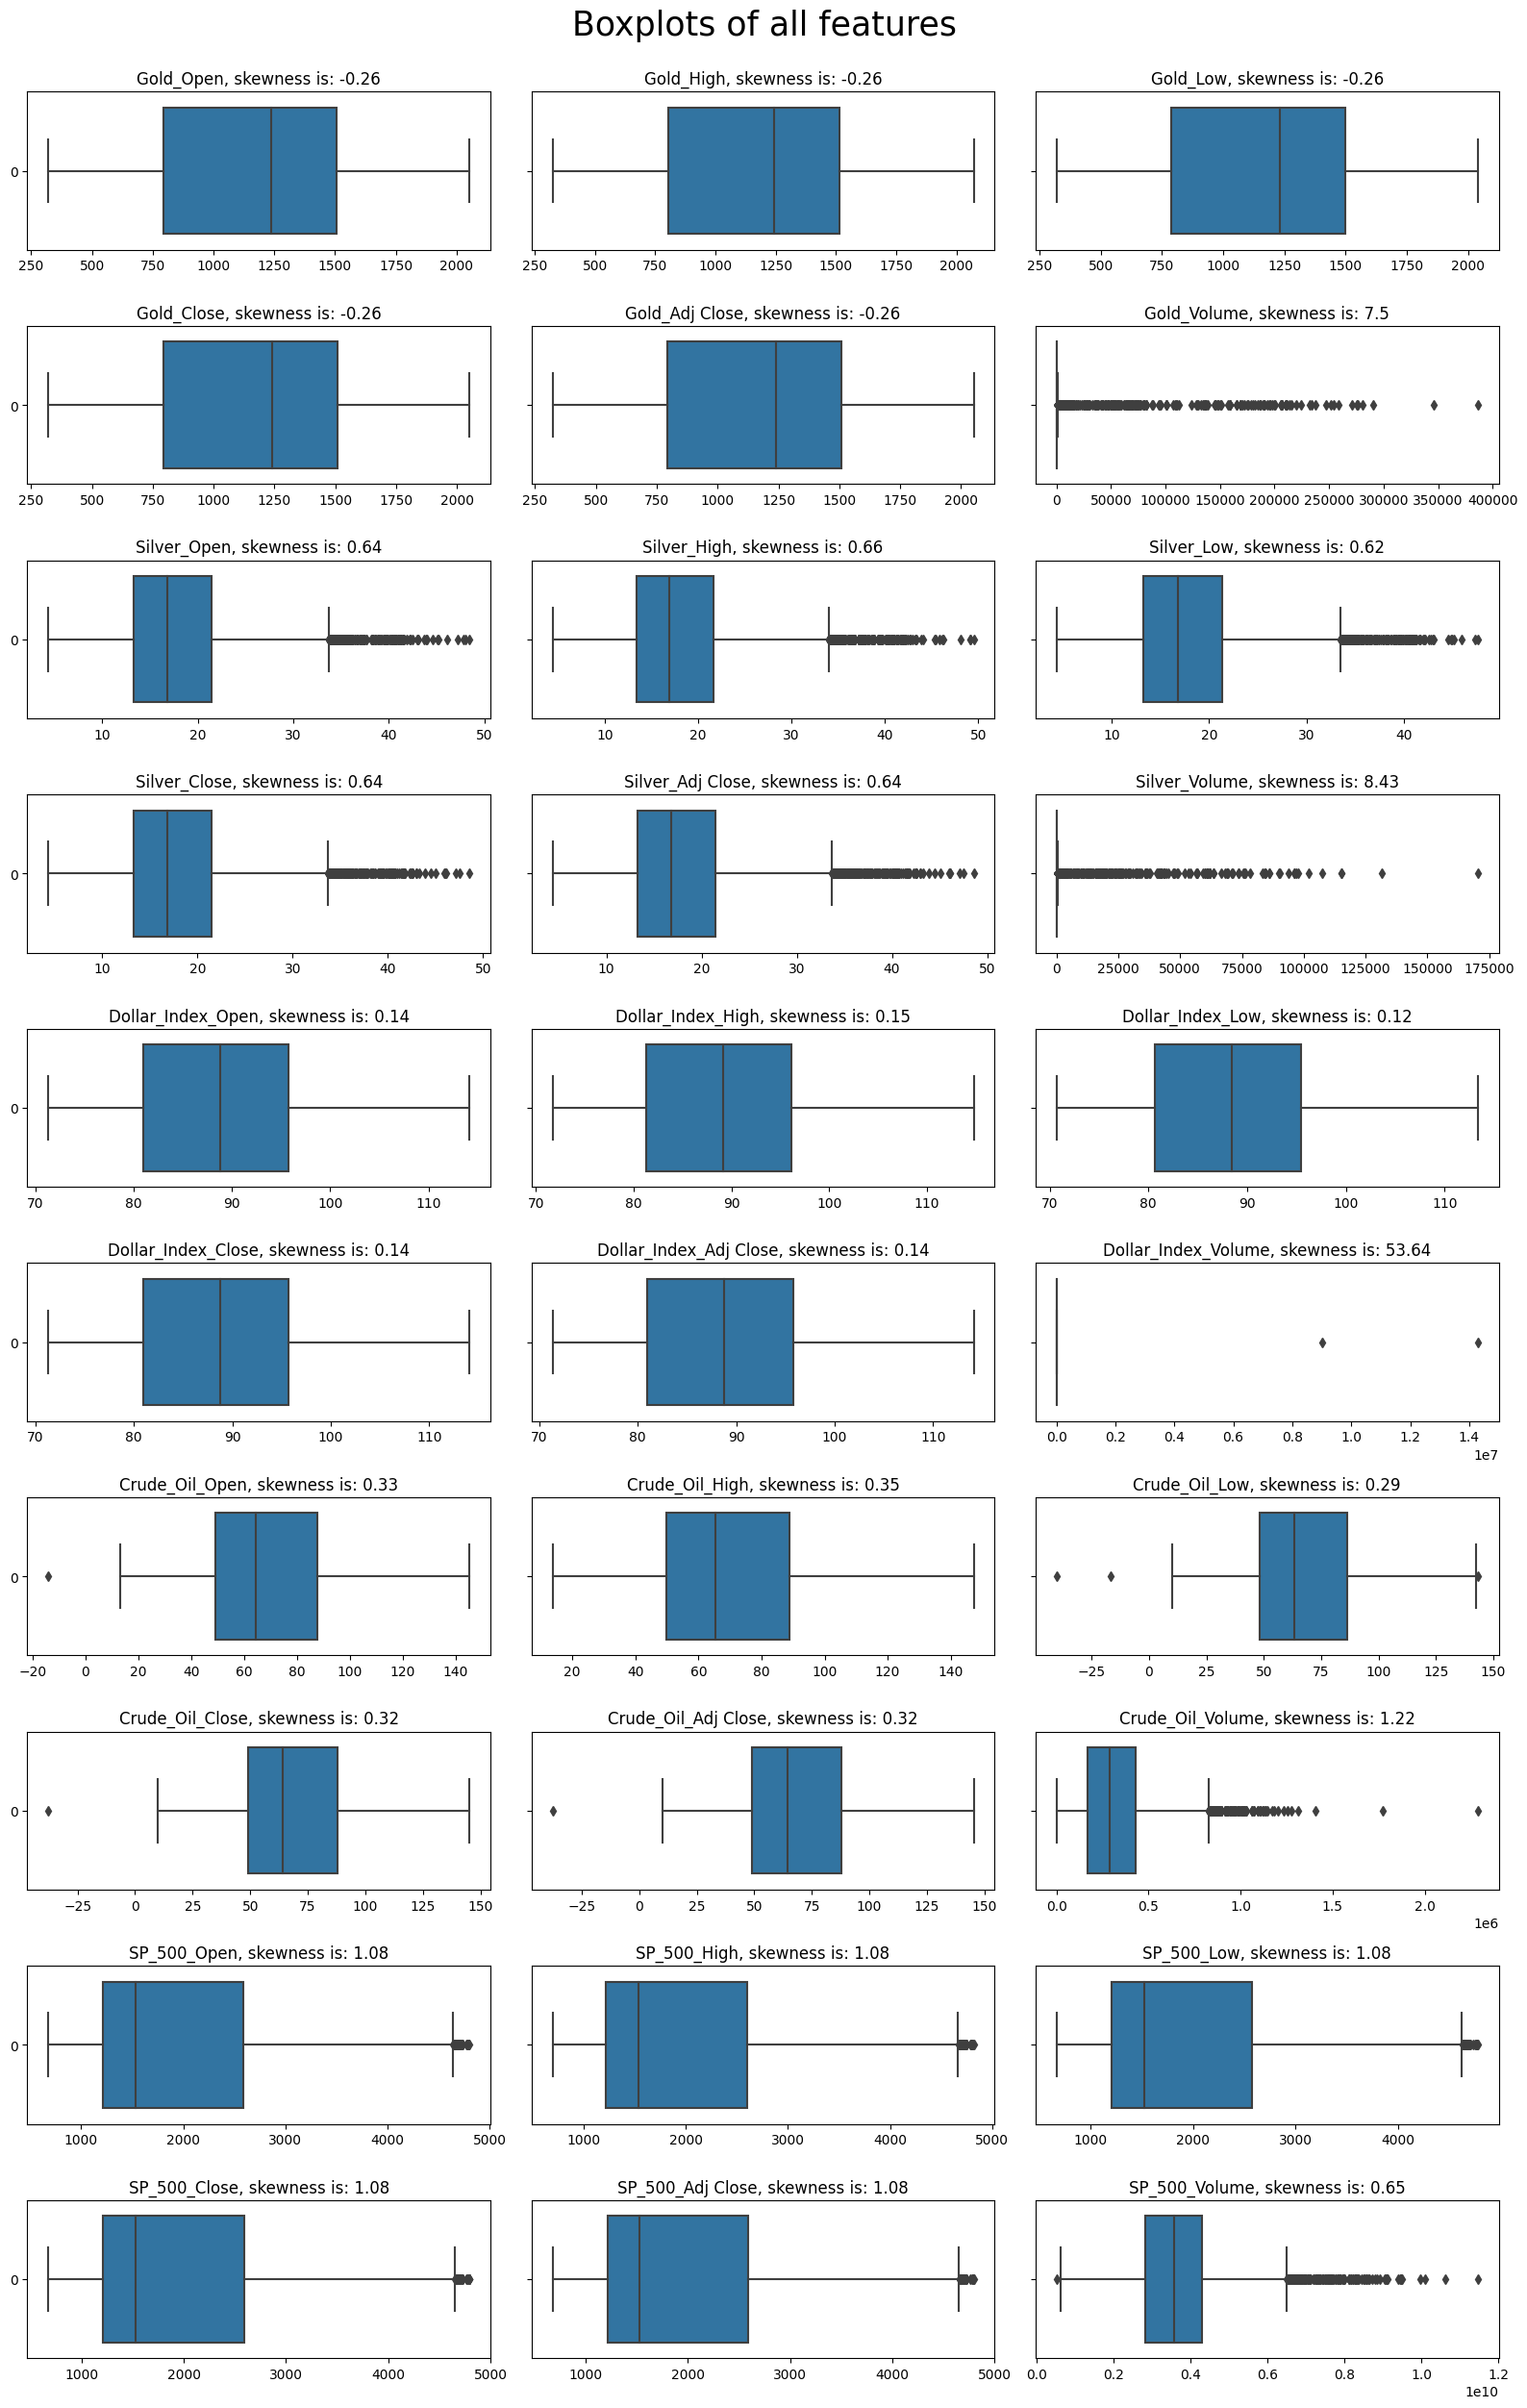

In [ ]:
def boxplots(df, col_list, rows, cols, subtitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16, 25))
    fig.suptitle(subtitle, y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(col_list):
        sns.boxplot(data=df[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: ' + str(round(df[data].skew(axis=0, skipna=True), 2)))

column_names = df.columns.tolist()

# Define the number of rows and columns for subplots
rows = 10  # Define the number of rows
cols = 3   # Define the number of columns

# Select a subset of columns to visualize
subset_columns = column_names[:rows * cols]

boxplots(df, col_list=subset_columns, rows=rows, cols=cols, subtitle='Boxplots of all features')

plt.tight_layout()
plt.show()

####Data Cleaning

In [ ]:
# Count the number of N/A values in each column
na_count_per_column = combined_data_df.isna().sum()
print('Number of N/A values in each column:\n', na_count_per_column)

Number of N/A values in each column:
 Date                           0
Gold_Open                      0
Gold_High                      0
Gold_Low                       0
Gold_Close                     0
Gold_Adj Close                 0
Gold_Volume                    0
Silver_Open                    0
Silver_High                    0
Silver_Low                     0
Silver_Close                   0
Silver_Adj Close               0
Silver_Volume                  0
Dollar_Index_Open              0
Dollar_Index_High              0
Dollar_Index_Low               0
Dollar_Index_Close             0
Dollar_Index_Adj Close         0
Dollar_Index_Volume            0
Crude_Oil_Open                 0
Crude_Oil_High                 0
Crude_Oil_Low                  0
Crude_Oil_Close                0
Crude_Oil_Adj Close            0
Crude_Oil_Volume               0
SP_500_Open                    0
SP_500_High                    0
SP_500_Low                     0
SP_500_Close                   0
SP_50

In [ ]:
# Perform forward fill imputation
combined_data_df['Inflation'] = combined_data_df['Inflation'].ffill()

In [ ]:
# Count number of zeroes in columns
zero_values = (combined_data_df == 0)
zero_count_per_column = zero_values.sum()
print('Number of 0 values in each column:\n', zero_count_per_column)

Number of 0 values in each column:
 Date                             0
Gold_Open                        0
Gold_High                        0
Gold_Low                         0
Gold_Close                       0
Gold_Adj Close                   0
Gold_Volume                    187
Silver_Open                      0
Silver_High                      0
Silver_Low                       0
Silver_Close                     0
Silver_Adj Close                 0
Silver_Volume                  433
Dollar_Index_Open                0
Dollar_Index_High                0
Dollar_Index_Low                 0
Dollar_Index_Close               0
Dollar_Index_Adj Close           0
Dollar_Index_Volume           5018
Crude_Oil_Open                   0
Crude_Oil_High                   0
Crude_Oil_Low                    0
Crude_Oil_Close                  0
Crude_Oil_Adj Close              0
Crude_Oil_Volume                 0
SP_500_Open                      0
SP_500_High                      0
SP_500_Low         

In [ ]:
# Set the 'Date' column as the DataFrame's index
combined_data_df.set_index('Date', inplace=True)

In [ ]:
#Check for negative values
columns_with_negative_values = combined_data_df.columns[combined_data_df.lt(0).any()]
print("Columns with negative values:")
print(columns_with_negative_values)

Columns with negative values:
Index(['Crude_Oil_Open', 'Crude_Oil_Low', 'Crude_Oil_Close',
       'Crude_Oil_Adj Close'],
      dtype='object')


####Feature Engineering

In [ ]:
# List of column names containing "_Volume"
volume_columns = [col for col in combined_data_df.columns if '_Volume' in col]
# Drop the volume columns
combined_data_df = combined_data_df.drop(columns=volume_columns)

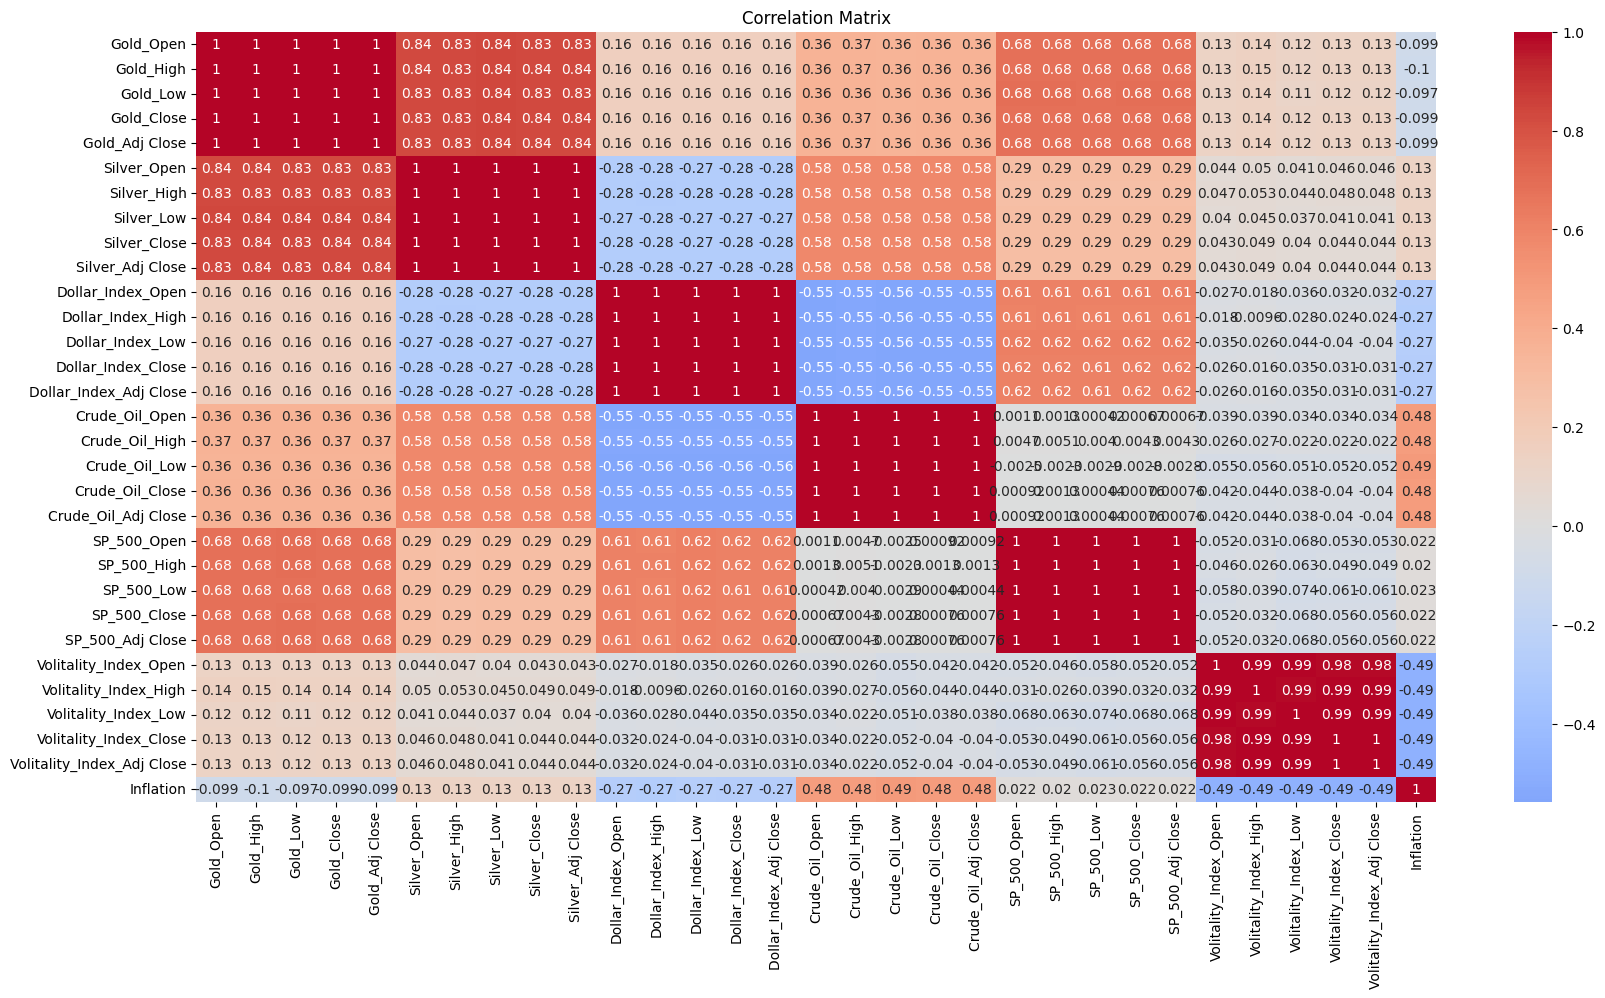

In [ ]:
# Calculate the correlation matrix
correlation_matrix = combined_data_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 10))

# Plot the correlation matrix heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation Matrix')
plt.show()

In [ ]:
# List of column names containing _Close,_Open, _High, _Low
remove_columns = [col for col in df.columns if col.endswith(('_Close', '_Open', '_High', '_Low'))]
# Drop the columns names ending with _Close,_Open, _High, _Low
combined_data_df = combined_data_df.drop(columns=remove_columns)

In [ ]:
#Log transform Crude_Oil_Adj Close
combined_data_df['Crude_Oil_Adj Close'] = np.log(combined_data_df['Crude_Oil_Adj Close'].abs() + 1)

In [ ]:
# Sort by date
combined_data_df = combined_data_df.sort_index()

In [ ]:
# Get the column names
column_names = combined_data_df.columns.tolist()

#Scale the data using Min Max scaler
# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Normalize the predictor variables (X)
X_scaled = scaler.fit_transform(combined_data_df)
# Convert the normalized NumPy array back to a DataFrame
normalized_df = pd.DataFrame(X_scaled, columns=column_names)

normalized_df.head()

,Gold_Adj Close,Silver_Adj Close,Dollar_Index_Adj Close,Crude_Oil_Adj Close,SP_500_Adj Close,Volitality_Index_Adj Close,Inflation
0,0.014220,0.010534,0.739832,0.422589,0.056432,0.220938,0.536913
1,0.017168,0.012342,0.727910,0.436799,0.056325,0.211285,0.530201
2,0.017457,0.012501,0.716223,0.425520,0.061281,0.214412,0.533557
3,0.014913,0.010353,0.730248,0.413420,0.059805,0.217403,0.530201
4,0.018728,0.011529,0.713885,0.407102,0.056650,0.222842,0.560403


###Common Functions

In [ ]:
#Function to create window
def create_window_2D(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        # Extract window
        window = data.iloc[i-window_size:i]
        # Append to X, y
        X.append(window.values)
        y.append(data.iloc[i]['Gold_Adj Close'])
    return np.array(X), np.array(y)

def create_windows_3D(data, window_size):
  X = []
  y = []
  for i in range(window_size, len(data)):
    window = data.iloc[i-window_size:i]
    X.append(window.values)
    # Create window for y
    y_window = data.iloc[i-window_size:i]['Gold_Adj Close'].values
    y.append(y_window)
  X = np.array(X)
  y = np.array(y)
  # Reshape y to match X
  y = y.reshape(y.shape[0], y.shape[1])
  return X, y

#Function to split data to train, val and test
def split_data(X,y, train_ratio=0.8):
    n_train = int(train_ratio * len(X))
    n_test = len(X) - n_train

    # Split into train
    X_train = X[:n_train]
    y_train = y[:n_train]

    # Split into test
    X_test = X[n_train:]
    y_test = y[n_train:]

    # Display the count of train test set
    print('X Train count: ' + str(len(X_train)))
    print('y Train count: ' + str(len(y_train)))
    print('X Test count: ' + str(len(X_test)))
    print('y Test count: ' + str(len(y_test)))

    return X_train, y_train, X_test, y_test


#Function check performance
def evaluate_performance(y_test, predictions,modelname):
    modelname_mse = mean_squared_error(y_test, predictions)
    modelname_rmse = np.sqrt(modelname_mse)
    modelname_mae = mean_absolute_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    modelname_mape = mape
    modelname_r2 = r2_score(y_test, predictions)
    print(modelname+" Mean Squared Error:", modelname_mse)
    print(modelname+" Root Mean Squared Error:", modelname_rmse)
    print(modelname+" Mean Absolute Error:", modelname_mae)
    print(modelname+" Mean Absolute Percentage Error:", modelname_mape)
    print(modelname+" R-squared:", modelname_r2)
    return modelname_mse,modelname_rmse,modelname_mae,modelname_mape,modelname_r2

#Function to combine results of models to form ensemble model prediction
def ensemble_pred(pred1, pred2, pred3):
    # Ensemble predictions using simple averaging
    ensemble_predictions = (pred1 + pred2 + pred3)/ 3
    return ensemble_predictions

#Function to plot performance
def plot_performance(y_test, prediction,model_name,array_size):
    if array_size==2:
      y_pred=prediction
      plt.figure(figsize=(10, 6))
      #y_pred_mean = prediction.mean(axis=1)
      plt.plot(y_test, label='Actual')
      plt.plot(y_pred,'o', label='Predicted',markersize=1)
      plt.xlabel('Time')
      plt.ylabel('Gold Price')
      plt.title(model_name+' Actual vs. Predicted')
      plt.legend()
      plt.show()
    elif array_size==3:
      plt.figure(figsize=(10, 6))
      y_test_mean = y_test.mean(axis=1)
      y_pred_mean = prediction.mean(axis=1)
      plt.plot(y_test_mean, label='Actual')
      plt.plot(y_pred_mean,'o', label='Predicted',markersize=1)
      plt.xlabel('Time')
      plt.ylabel('Gold Price')
      plt.title(model_name+' Actual vs. Predicted')
      plt.legend()
      plt.show()


###Individual models

####Create window and split data for simple models

In [ ]:
# Set attribute values
window_size=30
# Apply the rolling window function to create rolling windows
X_rolling, y_rolling = create_window_2D(normalized_df, window_size)

# Split the data into train, validation, and test sets
X_train, y_train, X_test, y_test = split_data(X_rolling, y_rolling)

# Reshape the 3D array of rolling windows to a 2D array
n_windows, window_size, n_features = X_train.shape
X_train_reshaped = X_train.reshape(n_windows, window_size * n_features)

# Reshape the 3D array of rolling windows to a 2D array
n_windows_test, window_size_test, n_features_test = X_test.shape
X_test_reshaped = X_test.reshape(n_windows_test, window_size_test * n_features_test)

X Train count: 3992
y Train count: 3992
X Test count: 998
y Test count: 998


####Random Forest model

In [ ]:
# Define and train Random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_reshaped, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Make predictions using Random forest model
rf_predictions = rf_model.predict(X_test_reshaped)

In [ ]:
#Evaluate performance of model
rf_mse,rf_rmse,rf_mae,rf_mape,rf_r2=evaluate_performance(y_test,rf_predictions,'rf')

rf Mean Squared Error: 0.0018608097970857734
rf Root Mean Squared Error: 0.043137104644212894
rf Mean Absolute Error: 0.028959179762868537
rf Mean Absolute Percentage Error: 3.376828734196666
rf R-squared: 0.8543919788946478


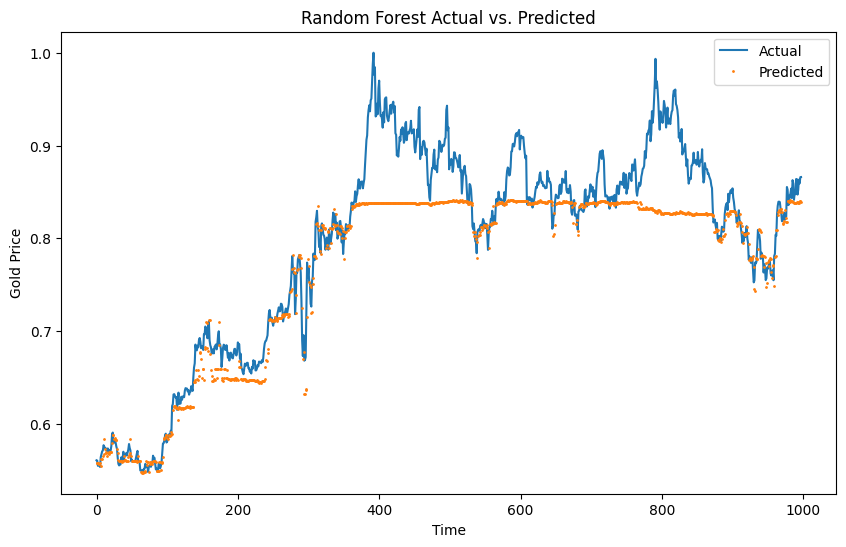

In [ ]:
#Plot performance of Random forest model
plot_performance(y_test, rf_predictions,'Random Forest',array_size=2)

####Support Vector Machine model

In [ ]:
# Create an SVR model
svr = SVR(kernel='rbf', C=100, gamma=0.1)

In [ ]:
# Train the model
svr.fit(X_train_reshaped, y_train)

SVR(C=100, gamma=0.1)

In [ ]:
# Make predictions
svm_predections = svr.predict(X_test_reshaped)

In [ ]:
#Evaluate performance of model
svm_mse,svm_rmse,svm_mae,svm_mape,svm_r2=evaluate_performance(y_test,svm_predections,'svm')

svm Mean Squared Error: 0.11115847148423576
svm Root Mean Squared Error: 0.33340436632449155
svm Mean Absolute Error: 0.309903861395396
svm Mean Absolute Percentage Error: 37.426423236270594
svm R-squared: -7.698129753650056


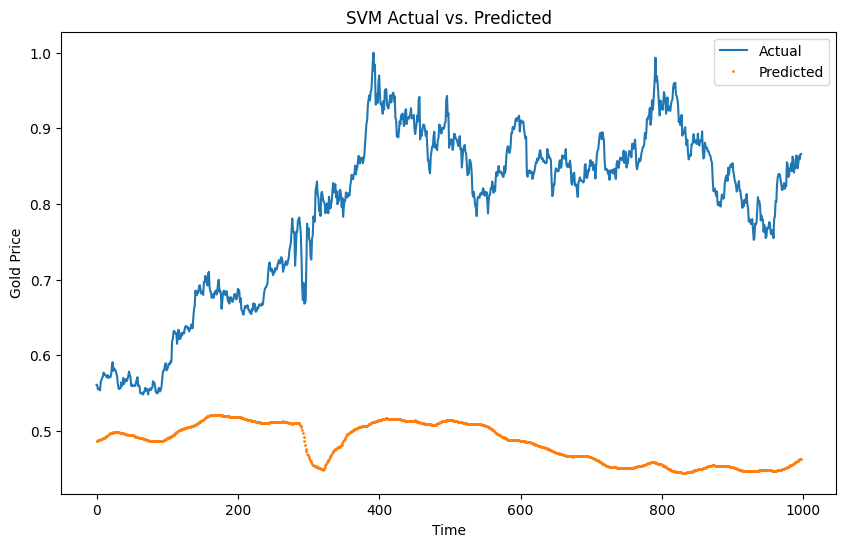

In [ ]:
#Plot performance of Random forest model
plot_performance(y_test, svm_predections,'SVM',array_size=2)

####XGBoost model

In [ ]:
# Define and train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
# Train the model
xgb_model.fit(X_train_reshaped, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# Make predictions
xgboost_predictions = xgb_model.predict(X_test_reshaped)

In [ ]:
#Evaluate performance of model
xgboost_mse,xgboost_rmse,xgboost_mae,xgboost_mape,xgboost_r2=evaluate_performance(y_test,xgboost_predictions,'xgboost')

xgboost Mean Squared Error: 0.002333129789596108
xgboost Root Mean Squared Error: 0.04830248223017227
xgboost Mean Absolute Error: 0.03345580275925375
xgboost Mean Absolute Percentage Error: 3.8365287894486717
xgboost R-squared: 0.8174330271814575


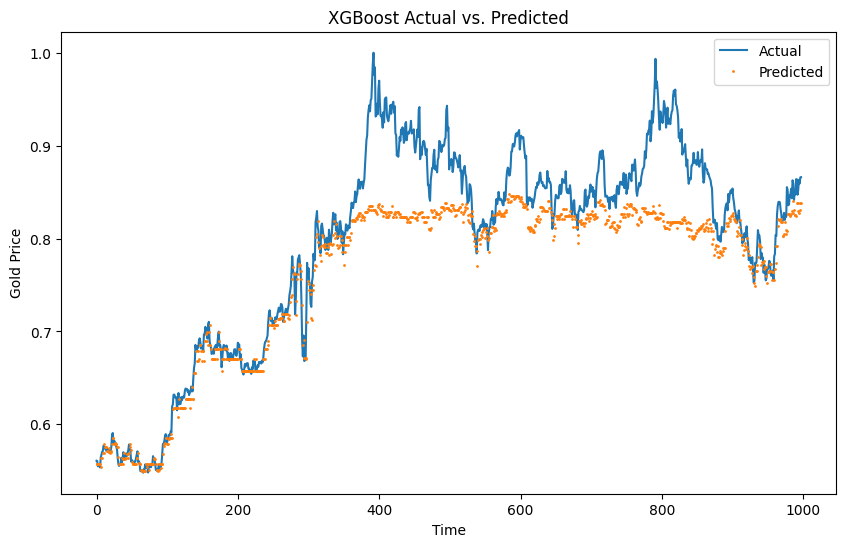

In [ ]:
#Plot performance of Random forest model
plot_performance(y_test, xgboost_predictions,'XGBoost',array_size=2)

####Create window and split data for deep learning models

In [ ]:
# Set attribute values
window_size=30
# Apply the rolling window function to create rolling windows
X_rolling, y_rolling = create_windows_3D(normalized_df, window_size)

# Split the data into train, validation, and test sets
X_train_3D, y_train_3D, X_test_3D, y_test_3D = split_data(X_rolling, y_rolling)

X Train count: 3992
y Train count: 3992
X Test count: 998
y Test count: 998


####LSTM(Long Short Term model)

In [ ]:
# Define and train LSTM model
lstm_model = Sequential()
# Add the layers
lstm_model = Sequential()
lstm_model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train_3D.shape[1], X_train_3D.shape[2])))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adamax', loss='mean_squared_error')
# Set Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Print the model summary
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            5120      
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 dense (Dense)               (None, 30, 1)             33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit(X_train_3D, y_train_3D, epochs=100, batch_size=32, validation_split=0.2,callbacks=[early_stopping], verbose=1)

Epoch 1/100
100/100 [==============================] - 10s 11ms/step - loss: 0.0446 - val_loss: 0.0210
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0210 - val_loss: 0.0145
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0157 - val_loss: 0.0112
Epoch 4/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0127 - val_loss: 0.0094
Epoch 5/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0107 - val_loss: 0.0077
Epoch 6/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0094 - val_loss: 0.0066
Epoch 7/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0084 - val_loss: 0.0057
Epoch 8/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 9/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 10/100
100/100 [==============================] - 2s 19ms/step - loss: 0.0065 - va

In [ ]:
#Make prediction using lstm model
lstm_predictions = lstm_model.predict(X_test_3D)

32/32 [==============================] - 1s 3ms/step


In [ ]:
# Reshape the LSTM predictions to match the shape of y_test
lstm_predictions_reshaped = lstm_predictions[:,:,0]
#Evaluate performance of model
lstm_mse,lstm_rmse,lstm_mae,lstm_mape,lstm_r2=evaluate_performance(y_test_3D,lstm_predictions_reshaped,'lstm')

lstm Mean Squared Error: 7.64618014934418e-05
lstm Root Mean Squared Error: 0.008744243906333
lstm Mean Absolute Error: 0.005737325868189261
lstm Mean Absolute Percentage Error: 0.7091126440852065
lstm R-squared: 0.9945741261499842


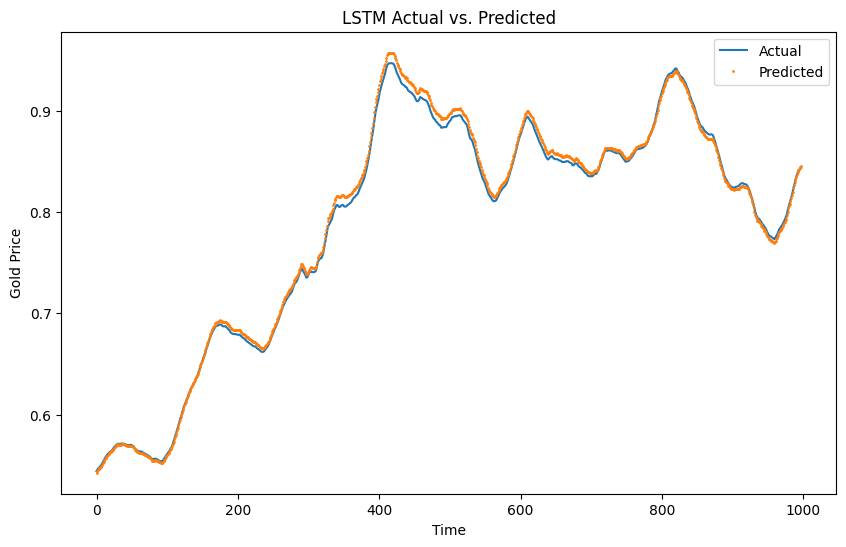

In [ ]:
#Plot performance of Random forest model
plot_performance(y_test_3D, lstm_predictions_reshaped,'LSTM',array_size=3)

####CNN(Convolutional Neural Network model)

In [ ]:
# Define and train CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train_3D.shape[1], X_train_3D.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(30))
cnn_model.compile(loss='mse', optimizer='adam')
# Set Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Print the model summary
cnn_model.summary()
# Fit model
cnn_model.fit(X_train_3D, y_train_3D, epochs=100, batch_size=32,validation_split=0.2,callbacks=[early_stopping], verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 32)            1152      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 416)               0         
                                                                 
 dense_1 (Dense)             (None, 30)                12510     
                                                                 
Total params: 13,662
Trainable params: 13,662
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 7s 7ms/step - loss: 0.0265 - val_loss: 0.0019
Epoch 2/100
100

In [ ]:
# Make prediction using cnn model
cnn_predictions = cnn_model.predict(X_test_3D)

32/32 [==============================] - 0s 2ms/step


In [ ]:
#Evaluate performance of model
cnn_mse,cnn_rmse, cnn_mae,cnn_mape,cnn_r2=evaluate_performance(y_test_3D,cnn_predictions,'cnn')

cnn Mean Squared Error: 0.0024771736750074966
cnn Root Mean Squared Error: 0.04977121331661
cnn Mean Absolute Error: 0.03330298206280714
cnn Mean Absolute Percentage Error: 4.045791121834213
cnn R-squared: 0.8167267019069838


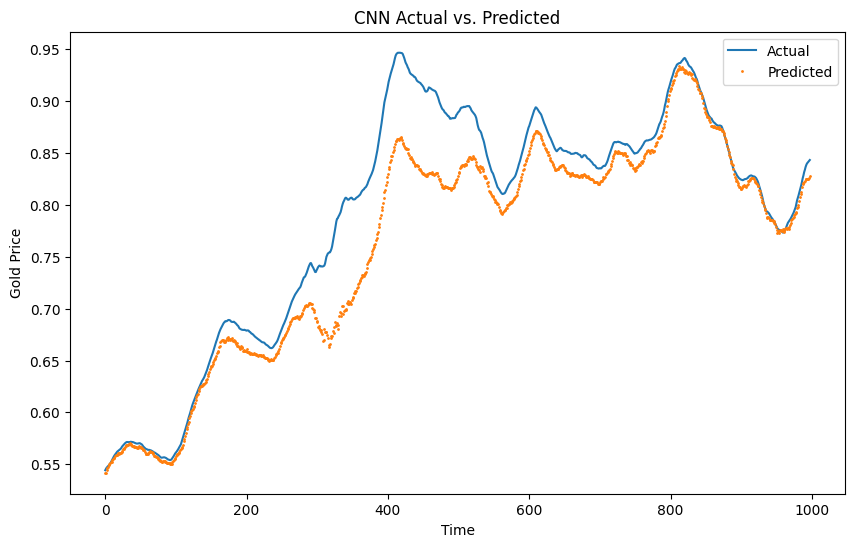

In [ ]:
#Plot performance of Random forest model
plot_performance(y_test_3D, cnn_predictions,'CNN',array_size=3)

####BLSTM(Bidirectional Long Short Term model)

In [ ]:
# Define and train BiLSTM model
blstm_model = Sequential()
# Add the layers
blstm_model.add(Bidirectional(LSTM(units=256, return_sequences=True), input_shape=(X_train_3D.shape[1], X_train_3D.shape[2])))
blstm_model.add(Dropout(0.3))
blstm_model.add(Dense(units=1))
# Compile the model
blstm_model.compile(optimizer='adamax', loss='mean_squared_error')
# Set Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Print the model summary
blstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 30, 512)          540672    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 30, 512)           0         
                                                                 
 dense_2 (Dense)             (None, 30, 1)             513       
                                                                 
Total params: 541,185
Trainable params: 541,185
Non-trainable params: 0
_________________________________________________________________


In [ ]:
blstm_hist=blstm_model.fit(X_train_3D, y_train_3D, epochs=100, batch_size=32, validation_split=0.2,callbacks=[early_stopping], verbose=1)

Epoch 1/100
100/100 [==============================] - 5s 16ms/step - loss: 0.0122 - val_loss: 0.0039
Epoch 2/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 4.9944e-04
Epoch 3/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 2.9127e-04
Epoch 4/100
100/100 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 2.7640e-04
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 2.2911e-04
Epoch 6/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 3.2293e-04
Epoch 7/100
100/100 [==============================] - 1s 12ms/step - loss: 0.0010 - val_loss: 2.0107e-04
Epoch 8/100
100/100 [==============================] - 1s 12ms/step - loss: 9.3196e-04 - val_loss: 2.4480e-04
Epoch 9/100
100/100 [==============================] - 1s 10ms/step - loss: 8.7651e-04 - val_loss: 2.4447e-04
Epoch 10/100
100/100 [========================

In [ ]:
# Make prediction using blstm model
blstm_predictions = blstm_model.predict(X_test_3D)

32/32 [==============================] - 1s 4ms/step


In [ ]:
# Reshape the LSTM predictions to match the shape of y_test
blstm_predictions_reshaped = blstm_predictions[:,:,0]
#Evaluate performance of model
blstm_mse,blstm_rmse,blstm_mae,blstm_mape,blstm_r2=evaluate_performance(y_test_3D,blstm_predictions_reshaped,'blstm')

blstm Mean Squared Error: 0.0009553887723495532
blstm Root Mean Squared Error: 0.030909363829583314
blstm Mean Absolute Error: 0.022926433973632917
blstm Mean Absolute Percentage Error: 2.8326062518830306
blstm R-squared: 0.92857318766582


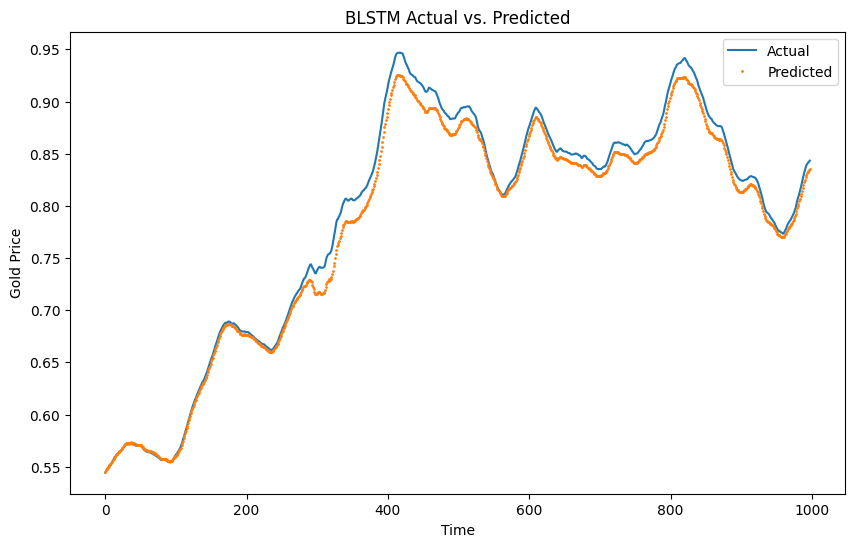

In [ ]:
#Plot performance of Random forest model
plot_performance(y_test_3D, blstm_predictions_reshaped,'BLSTM',array_size=3)

####Summarize Performance of all individual models

In [ ]:
# Create a dictionary to store the model results
model_results = {
    'Model': ['Random Forest', 'SVM', 'XGBoost', 'LSTM', 'CNN', 'BLSTM'],
    'Mean Squared Error': [rf_mse, svm_mse, xgboost_mse, lstm_mse, cnn_mse, blstm_mse],
    'Root Mean Squared Error': [rf_rmse, svm_rmse, xgboost_rmse, lstm_rmse, cnn_rmse, blstm_rmse],
    'Mean Absolute Error': [rf_mae, svm_mae, xgboost_mae, lstm_mae, cnn_mae, blstm_mae],
    'Mean Absolute Percentage Error': [rf_mape, svm_mape, xgboost_mape, lstm_mape, cnn_mape, blstm_mape],
    'R-squared': [rf_r2, svm_r2, xgboost_r2, lstm_r2, cnn_r2, blstm_r2]
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(model_results)


# Print the table using the tabulate library
table = tabulate(results_df, headers='keys', tablefmt='grid')
print(table)

+----+---------------+----------------------+---------------------------+-----------------------+----------------------------------+-------------+
|    | Model         |   Mean Squared Error |   Root Mean Squared Error |   Mean Absolute Error |   Mean Absolute Percentage Error |   R-squared |
+====+===============+======================+===========================+=======================+==================================+=============+
|  0 | Random Forest |          0.00186081  |                0.0431371  |            0.0289592  |                         3.37683  |    0.854392 |
+----+---------------+----------------------+---------------------------+-----------------------+----------------------------------+-------------+
|  1 | SVM           |          0.111158    |                0.333404   |            0.309904   |                        37.4264   |   -7.69813  |
+----+---------------+----------------------+---------------------------+-----------------------+---------------------

####Reshape model prediction

In [ ]:
# Repeat each prediction to create 30 timesteps
rf_predictions_reshaped = np.repeat(rf_predictions, 30)
# Reshape into 2D
rf_predictions_reshaped = rf_predictions_reshaped.reshape(-1, 30)

# Repeat each prediction to create 7 timesteps
xg_boost_predictions_reshaped = np.repeat(xgboost_predictions, 30)
# Reshape into 2D
xg_boost_predictions_reshaped = xg_boost_predictions_reshaped.reshape(-1, 30)

# Reshape the LSTM predictions to match the shape of y_test
lstm_predictions_reshaped = lstm_predictions[:,:,0]
lstm_predictions_reshaped.shape

# Reshape the LSTM predictions to match the shape of y_test
blstm_predictions_reshaped = blstm_predictions[:,:,0]
blstm_predictions_reshaped.shape

#Display shape of rf_predictions
print(rf_predictions_reshaped.shape)
print(xg_boost_predictions_reshaped.shape)
print(cnn_predictions.shape)
print(lstm_predictions_reshaped.shape)
print(blstm_predictions_reshaped.shape)

(998, 30)
(998, 30)
(998, 30)
(998, 30)
(998, 30)


###Ensemble Models

####Ensemble predictions set1: Random Forest, CNN,LSTM

Ensemblemodel1 Mean Squared Error: 0.0007093015389290765
Ensemblemodel1 Root Mean Squared Error: 0.026632715575567515
Ensemblemodel1 Mean Absolute Error: 0.019647780619090414
Ensemblemodel1 Mean Absolute Percentage Error: 2.3596400361294
Ensemblemodel1 R-squared: 0.9476912840988873


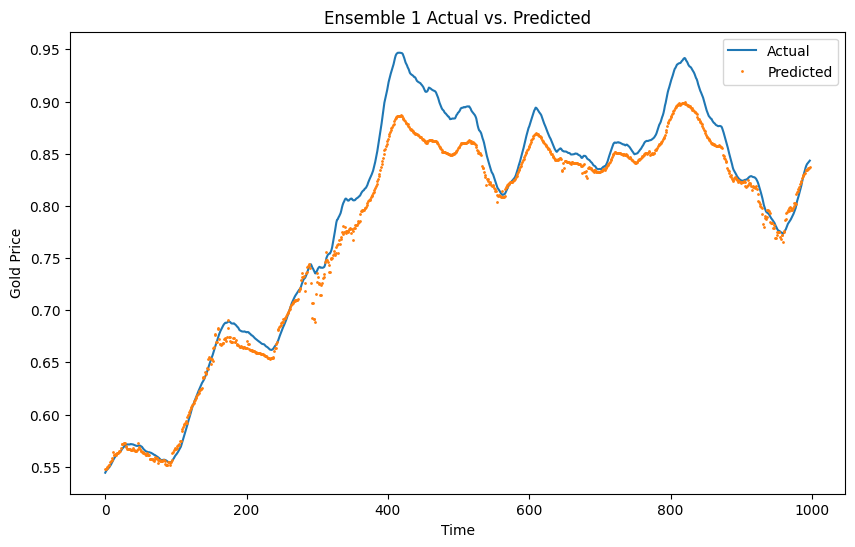

In [ ]:
#Get Ensemble model prediction
ensemble_predictions_1=ensemble_pred(rf_predictions_reshaped, cnn_predictions, lstm_predictions_reshaped)
#Evaluate Ensemble model prediction
Ensemblemodel1_mse,Ensemblemodel1_rmse,Ensemblemodel1_mae,Ensemblemodel1_mape,Ensemblemodel1_r2=evaluate_performance(y_test_3D, ensemble_predictions_1,'Ensemblemodel1')
#Plot Ensemble model prediction
plot_performance(y_test_3D, ensemble_predictions_1,'Ensemble 1',3)

####Ensemble model set2: XGBoost, CNN,LSTM

Ensemblemodel2 Mean Squared Error: 0.000816368883753396
Ensemblemodel2 Root Mean Squared Error: 0.02857216974178538
Ensemblemodel2 Mean Absolute Error: 0.02108168519609163
Ensemblemodel2 Mean Absolute Percentage Error: 2.5092033860470173
Ensemblemodel2 R-squared: 0.9398069537357956


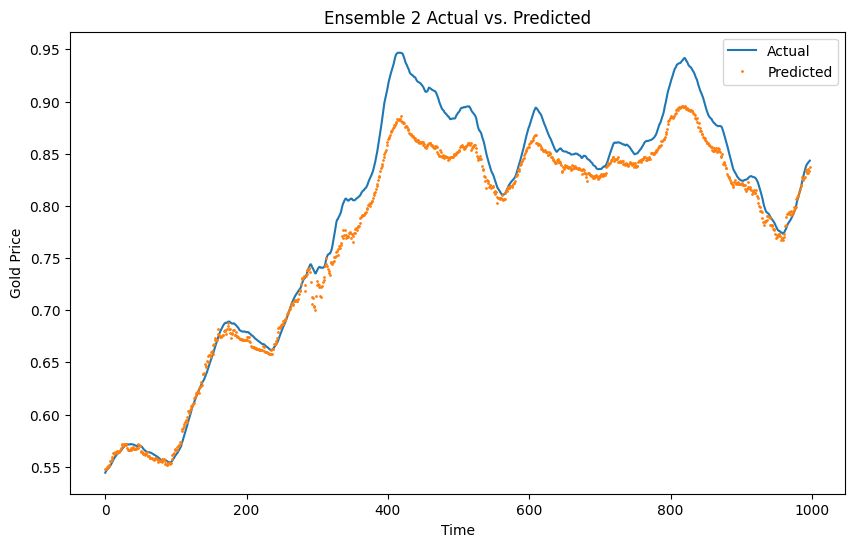

In [ ]:
#Get Ensemble model prediction
ensemble_predictions_2=ensemble_pred(xg_boost_predictions_reshaped, cnn_predictions, lstm_predictions_reshaped)
#Evaluate Ensemble model prediction
Ensemblemodel2_mse,Ensemblemodel2_rmse,Ensemblemodel2_mae,Ensemblemodel2_mape,Ensemblemodel2_r2=evaluate_performance(y_test_3D, ensemble_predictions_2,'Ensemblemodel2')
#Plot Ensemble model prediction
plot_performance(y_test_3D, ensemble_predictions_2,'Ensemble 2',3)

####Ensemble model set3: Random Forest, CNN, BLSTM

Ensemblemodel3 Mean Squared Error: 0.0011423654341461648
Ensemblemodel3 Root Mean Squared Error: 0.03379889693682569
Ensemblemodel3 Mean Absolute Error: 0.025392314687249885
Ensemblemodel3 Mean Absolute Percentage Error: 3.0681451401267745
Ensemblemodel3 R-squared: 0.915250385350815


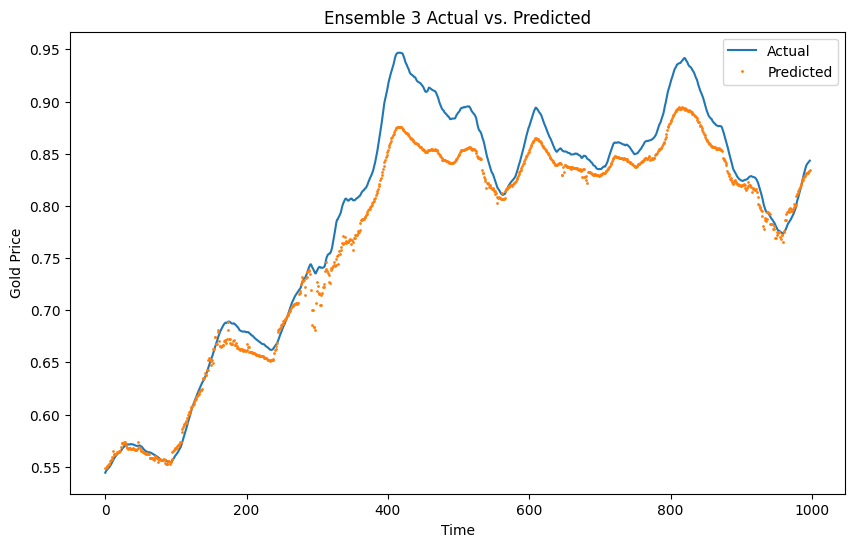

In [ ]:
#Get Ensemble model prediction
ensemble_predictions_3=ensemble_pred(rf_predictions_reshaped, cnn_predictions, blstm_predictions_reshaped)
#Evaluate Ensemble model prediction
Ensemblemodel3_mse,Ensemblemodel3_rmse,Ensemblemodel3_mae,Ensemblemodel3_mape,Ensemblemodel3_r2=evaluate_performance(y_test_3D, ensemble_predictions_3,'Ensemblemodel3')
#Plot Ensemble model prediction
plot_performance(y_test_3D, ensemble_predictions_3,'Ensemble 3',3)

####Ensemble model set4: XGBoost, CNN, BLSTM

Ensemblemodel4 Mean Squared Error: 0.0012746674347416948
Ensemblemodel4 Root Mean Squared Error: 0.03570248499392857
Ensemblemodel4 Mean Absolute Error: 0.026817828869339644
Ensemblemodel4 Mean Absolute Percentage Error: 3.217373964697328
Ensemblemodel4 R-squared: 0.9054454955830039


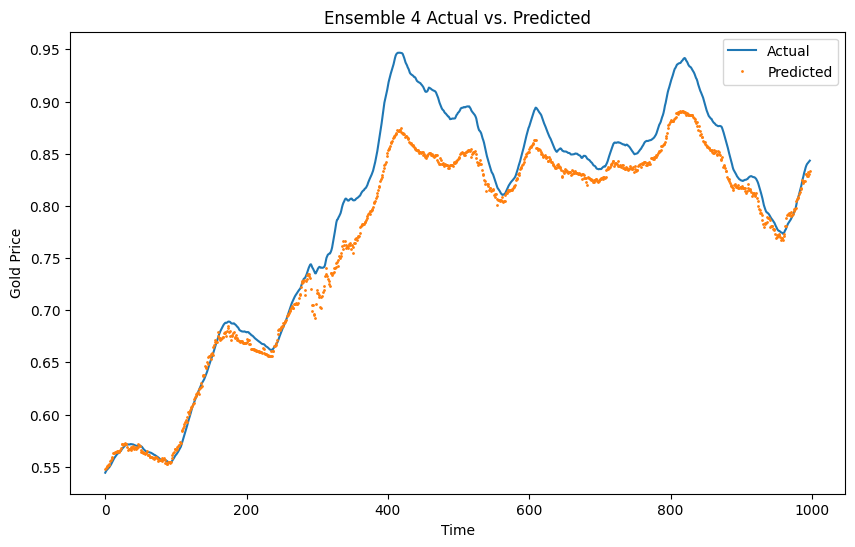

In [ ]:
#Get Ensemble model prediction
ensemble_predictions_4=ensemble_pred(xg_boost_predictions_reshaped, cnn_predictions, blstm_predictions_reshaped)
#Evaluate Ensemble model prediction
Ensemblemodel4_mse,Ensemblemodel4_rmse,Ensemblemodel4_mae,Ensemblemodel4_mape,Ensemblemodel4_r2=evaluate_performance(y_test_3D, ensemble_predictions_4,'Ensemblemodel4')
#Plot Ensemble model prediction
plot_performance(y_test_3D, ensemble_predictions_4,'Ensemble 4',3)

####Summarize Performance of all ensemble models

In [ ]:
# Create a dictionary to store the model results
model_results = {
    'Model': ['Ensemble model set1', 'Ensemble model set2', 'Ensemble model set3', 'Ensemble model set4'],
    'Mean Squared Error': [Ensemblemodel1_mse, Ensemblemodel2_mse,Ensemblemodel3_mse,Ensemblemodel4_mse],
    'Root Mean Squared Error': [Ensemblemodel1_rmse,Ensemblemodel2_rmse,Ensemblemodel3_rmse,Ensemblemodel4_rmse],
    'Mean Absolute Error': [Ensemblemodel1_mae, Ensemblemodel2_mae,Ensemblemodel3_mae,Ensemblemodel4_mae],
    'Mean Absolute Percentage Error': [Ensemblemodel1_mape, Ensemblemodel2_mape, Ensemblemodel3_mape, Ensemblemodel4_mape],
    'R-squared': [Ensemblemodel1_r2,Ensemblemodel2_r2,Ensemblemodel3_r2,Ensemblemodel4_r2]
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(model_results)


# Print the table using the tabulate library
table = tabulate(results_df, headers='keys', tablefmt='grid')
print(table)

+----+---------------------+----------------------+---------------------------+-----------------------+----------------------------------+-------------+
|    | Model               |   Mean Squared Error |   Root Mean Squared Error |   Mean Absolute Error |   Mean Absolute Percentage Error |   R-squared |
+====+=====================+======================+===========================+=======================+==================================+=============+
|  0 | Ensemble model set1 |          0.000709302 |                 0.0266327 |             0.0196478 |                          2.35964 |    0.947691 |
+----+---------------------+----------------------+---------------------------+-----------------------+----------------------------------+-------------+
|  1 | Ensemble model set2 |          0.000816369 |                 0.0285722 |             0.0210817 |                          2.5092  |    0.939807 |
+----+---------------------+----------------------+---------------------------+---

####Forecast

In [ ]:
def roll_window(input_data, new_value):
    # Roll input data to drop oldest window
    rolled = np.roll(input_data, -1, axis=1)
    # Add new prediction to the end of the last window
    rolled[:, -1, 0] = new_value
    return rolled

# Set attribute values
window_size=30
# # Apply the rolling window function to create rolling windows
X_rolling_f2D, y_rolling_2D = create_window_2D(normalized_df, window_size)
X_rolling_2D_reshaped = X_rolling_f2D.reshape(X_rolling_f2D.shape[0], window_size * n_features)
window_size=30
# Reshape the 3D array of rolling windows to a 2D array
X_rolling_3D, y_rolling_3D = create_windows_3D(normalized_df, window_size)

rf_model.fit(X_rolling_2D_reshaped, y_rolling_2D)
cnn_model.fit(X_rolling_3D, y_rolling_3D)
lstm_model.fit(X_rolling_3D, y_rolling_3D)

# Create input for forecasting
last_30_days = normalized_df[-30:]
last_30_days_np = last_30_days.to_numpy()
# Reshape for RF
last_30_days_rf = last_30_days_np.reshape(1, -1)
# Add timestep dimension for CNN
last_30_days_cnn = last_30_days_np.reshape(1, last_30_days_np.shape[0], last_30_days.shape[1])
# Same reshape for LSTM
last_30_days_lstm = last_30_days_np.reshape(1, last_30_days_np.shape[0], last_30_days.shape[1])

# Forecast for 30 days
for i in range(30):
  rf_pred = rf_model.predict(last_30_days_rf)
  cnn_pred = cnn_model.predict(last_30_days_cnn)
  lstm_pred = lstm_model.predict(last_30_days_lstm)
  ensemble_pred = (rf_pred + cnn_pred + lstm_pred)/3
  # Extract scalar prediction
  ensemble_gold_adj_close = ensemble_pred[0, -1, 0]
  # Assign prediction
  last_30_days = roll_window(last_30_days_lstm, ensemble_gold_adj_close)

1/1 [==============================] - 0s 30ms/step


In [ ]:
# Create a DataFrame from last_30_days_lstm
last_30_days_df = pd.DataFrame(last_30_days[0], columns=normalized_df.columns)

# Concatenate normalized_df and last_30_days_df
combined_df_1 = pd.concat([normalized_df, last_30_days_df])

In [ ]:
# Check the number of rows and columns
num_rows = combined_df_1.shape[0]
num_columns = combined_df_1.shape[1]
print(f"The dataset has {num_rows} rows and {num_columns} columns.")

The dataset has 5050 rows and 7 columns.


In [ ]:
# Inverse transform the entire DataFrame
complete_df_inverse = pd.DataFrame(scaler.inverse_transform(combined_df_1), columns=combined_df_1.columns)

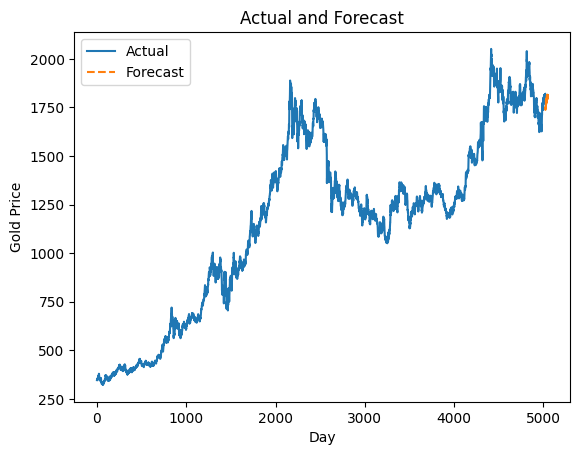

In [ ]:
# Actual values
actual = complete_df_inverse['Gold_Adj Close'][:-30]

# Forecast values
forecast = complete_df_inverse['Gold_Adj Close'][-30:]

# Plot actual values
plt.plot(actual, label='Actual')

# Shift x-axis for forecast values
forecast_indices = range(len(actual), len(actual) + len(forecast))
plt.plot(forecast_indices, forecast, label='Forecast', linestyle='dashed')

plt.title('Actual and Forecast')
plt.xlabel('Day')
plt.ylabel('Gold Price')
plt.legend()

plt.show()

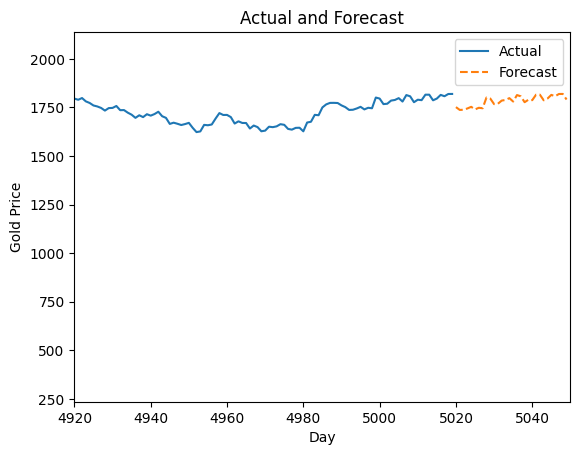

In [ ]:
# Actual values
actual = complete_df_inverse['Gold_Adj Close'][:-30]

# Forecast values
forecast = complete_df_inverse['Gold_Adj Close'][-30:]

# Plot actual values
plt.plot(actual, label='Actual')

# Shift x-axis for forecast values
forecast_indices = range(len(actual), len(actual) + len(forecast))
plt.plot(forecast_indices, forecast, label='Forecast', linestyle='dashed')
# Set x-axis limit to show the last 100 values
plt.xlim(len(actual) - 100, len(actual) + len(forecast))

plt.title('Actual and Forecast')
plt.xlabel('Day')
plt.ylabel('Gold Price')
plt.legend()

plt.show()

In [ ]:
# Get the last 60 rows of the DataFrame
last_60_rows = complete_df_inverse['Gold_Adj Close'][-60:]

# Print the table
print(last_60_rows)

4990    1760.800049
4991    1751.900024
4992    1737.400024
4993    1738.300049
4994    1744.900024
4995    1753.300049
4996    1740.099976
4997    1748.400024
4998    1746.000000
4999    1801.099976
5000    1795.900024
5001    1767.400024
5002    1769.300049
5003    1785.500000
5004    1788.699951
5005    1798.099976
5006    1780.500000
5007    1813.900024
5008    1807.500000
5009    1777.199951
5010    1790.000000
5011    1787.699951
5012    1815.900024
5013    1815.900024
5014    1787.000000
5015    1795.900024
5016    1814.800049
5017    1807.900024
5018    1819.500000
5019    1819.699951
5020    1751.900024
5021    1737.400024
5022    1738.300049
5023    1744.900024
5024    1753.300049
5025    1740.099976
5026    1748.400024
5027    1746.000000
5028    1801.099976
5029    1795.900024
5030    1767.400024
5031    1769.300049
5032    1785.500000
5033    1788.699951
5034    1798.099976
5035    1780.500000
5036    1813.900024
5037    1807.500000
5038    1777.199951
5039    1790.000000
